# Investigating Polysaccharide Utilization Loci (PULs) in Microbial Genomes

## Introduction:

In this Jupyter notebook, we will investigate the occurrence of Polysaccharide Utilization Loci (PULs) within microbial genomes. We begin by gathering diverse bacterial taxa from the bv-brc.org database. We then employ Prodigal for gene prediction and Diamond for similarity searches against a PUL database.

The primary goal is to uncover if finding a PUL match in one sequence corresponds to discovering another PUL match in its genomic vicinity or neighbourhood. By analysing these co-occurrence patterns, this may help to shed light on the functional roles and biological implications of PULs within microbial genomes. This notebook serves as a comprehensive guide to our exploration of PULs within genomes, providing insights into their distribution and occurrence.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from statistics import mean
from plotnine import ggplot, aes, geom_line, theme, geom_bin2d, scale_fill_gradient, geom_boxplot, geom_vline, geom_bar, element_text #, size
from plotnine.geoms import geom_histogram, geom_point
import math
import h5py
import random

from Bio import SeqIO
import seaborn as sns


## To do:

- redefine 'match'; eg >2 matches in same contig to same PUL
- create lookup (or similar) to assign contigs back to taxa
- change the 'score' to make more sense
    - 'no.clusters/no. matches against contig length' graph - either delete or change to whatever 'score' is
    - hyp test: dist of PUL labels across clusters are random?

- bvr website; see how many of the classes are represented in each cluster eg susc, susd, cbms etc

- grep to colour by taxa

## Initialising the data and putting into DataFrames:

In [2]:
PUL_embeddings = []
PUL_keys = []
with h5py.File('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\PUL.h5', 'r') as f:
    for key in f.keys():
      PUL_embeddings.append(f[key][()])
      PUL_keys.append(key)

In [3]:
f_path = 'C:\\Users\\alpha\\OneDrive - University of Cambridge\\BACKUP 14-04-22\\docs\\Maths\\SRIM\\code\\PUL.faa'
PUL_array, PUL_keys2 = [], []
with open(f_path, mode='r') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        identifier, description = record.id, record.description
        PUL_keys2.append(identifier)
        if 'CAZyme' in description:
            PUL_array.append(1)
        else:
            PUL_array.append(0)
PUL_array = np.array(PUL_array)
PUL_array = PUL_array.reshape(np.shape(PUL_array)[0],-1)
PUL_array_df = pd.DataFrame(PUL_array, index=PUL_keys2,columns=['cazy'])

col_label=['emb'+str(i) for i in range(len(list(PUL_embeddings)[0]))]

PUL_embeddings_list=list(PUL_embeddings)
temp_df = pd.DataFrame(PUL_embeddings_list, index=PUL_keys, columns=['emb'+str(i) for i in range(len(list(PUL_embeddings)[0]))])

PUL_df = temp_df.join(PUL_array_df)

In [4]:
# matches_df = pd.read_csv('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\diamond-windows\\matches.tsv',header=None, sep='\t')
matches_df = pd.read_csv('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\diamond-windows\\matches.tsv',names=['qid', 'sid', 'pident', 'qlength', 'qstart', 'qend', 'slength', 'sstart', 'send', 'evalue', 'bitscore'], sep='\t')


In [5]:
from Bio import SeqIO
import seaborn as sns
f_path = 'C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\diamond-windows\\jennifer_genomes.nr.fasta'
id_list=[]

with open(f_path, mode='r') as handle:
    ind=0
    for record in SeqIO.parse(handle, 'fasta'):
        ind=ind+1
        identifier = record.id
        id_list.append(identifier)

# print(id_list)
        

In [6]:
matches_df.iloc[4:10,:]

qid          sid  pident  qlength  qstart  qend  slength  \
4   accn|CP129981_9  PUL0460_102    24.6      162      12   149      154   
5  accn|CP129981_13    PUL0049_7    22.8      476      88   407      398   
6  accn|CP129981_13    PUL0127_1    36.2      476       3    71      243   
7  accn|CP129981_13    PUL0053_2    39.2      476       3    96      247   
8  accn|CP129981_13    PUL0052_2    36.7      476       3   100      253   
9  accn|CP129981_13    PUL0151_5    46.7      476      22    66      242   

   sstart  send        evalue  bitscore  
4      18   151  5.760000e-10      53.1  
5      15   327  1.630000e-10      60.8  
6       6    74  4.180000e-06      46.2  
7       6    96  5.750000e-06      45.8  
8       7    97  5.980000e-06      45.8  
9      33    77  9.940000e-06      45.1

In [7]:
id_list.index('accn|JAUDZE010000025_2')
len(id_list)
#both matches_df[:,0] and id_list has qid in alphabetical order for contigs then numerical order for ORFs

760729

## Distribution of matches to PUL file:

To see if one match correlates to more matches in the same neighbourhood

In [8]:
# matches_default_df = pd.read_csv('C:\\Users\\alpha\\Documents\\jennifer\\maths\\SRIM\\code\\diamond-windows\\matches_default.tsv',names=['qid', 'sid', 'pident', 'qlength', 'qstart', 'qend', 'slength', 'sstart', 'send', 'evalue', 'bitscore'], sep='\t')

# #631919 rows
# #matches_df: 1839477 rows

Create `subcat`: a list of lists, which groups ORFs in the same contig together:

In [11]:
# grouping ORFs in the same contig together:

a=list(matches_df.iloc[:,0])
test_list = list(dict.fromkeys(a))
print('1 ok')
# test_list = list(set(matches_df.iloc[:,0])) #exclude repeats of the same ORF
# len(test_list)

def util_func(x, y): return x[0] == y[0]

subcat = []
for sub in test_list:
    ele = sub.split('_')
    ele_cat = next((x for x in subcat if util_func(ele,str(x[0]).split('_'))), [])
    if ele_cat == []:
        subcat.append(ele_cat)
    ele_cat.append(sub)

print("list after categorisation : " + str(subcat))
len(subcat)

ind=0
match_count=[]
for i in range(len(subcat)):
    indtemp=ind
    match_count.append(len(subcat[i]))
    ind=indtemp+len(subcat[i])

#takes ~11 min

1 ok
list after categorisation : [['accn|CP129981_1', 'accn|CP129981_2', 'accn|CP129981_7', 'accn|CP129981_9', 'accn|CP129981_13', 'accn|CP129981_15', 'accn|CP129981_20', 'accn|CP129981_25', 'accn|CP129981_29', 'accn|CP129981_31', 'accn|CP129981_34', 'accn|CP129981_42', 'accn|CP129981_45', 'accn|CP129981_47', 'accn|CP129981_48', 'accn|CP129981_49', 'accn|CP129981_51', 'accn|CP129981_52', 'accn|CP129981_63', 'accn|CP129981_64', 'accn|CP129981_69', 'accn|CP129981_70', 'accn|CP129981_73', 'accn|CP129981_75', 'accn|CP129981_79', 'accn|CP129981_86', 'accn|CP129981_90', 'accn|CP129981_92', 'accn|CP129981_95', 'accn|CP129981_97', 'accn|CP129981_99', 'accn|CP129981_100', 'accn|CP129981_102', 'accn|CP129981_103', 'accn|CP129981_119', 'accn|CP129981_123', 'accn|CP129981_124', 'accn|CP129981_128', 'accn|CP129981_130', 'accn|CP129981_131', 'accn|CP129981_132', 'accn|CP129981_136', 'accn|CP129981_139', 'accn|CP129981_141', 'accn|CP129981_190', 'accn|CP129981_217', 'accn|CP129981_226', 'accn|CP12998

### Similarly for PULs: (to be used for investigating mixing, etc)

In [12]:
# Similarly for PULs: (to be used for investigating mixing etc)
subcat_PULs = []

a=list(PUL_keys2)
test_list = a #list(dict.fromkeys(a))
print('1 ok')
def util_func(x, y): return x[0] == y[0]

for sub in test_list:
    ele = sub.split('_')
    ele_cat = next((x for x in subcat_PULs if util_func(ele,str(x[0]).split('_'))), [])
    if ele_cat == []:
        subcat_PULs.append(ele_cat)
    ele_cat.append(sub)

print("PULs after categorisation : " + str(subcat_PULs))
len(subcat_PULs)

ind=0
match_count=[]
for i in range(len(subcat_PULs)):
    indtemp=ind
    match_count.append(len(subcat_PULs[i]))
    ind=indtemp+len(subcat_PULs[i])


1 ok
PULs after categorisation : [['PUL0001_1', 'PUL0001_2', 'PUL0001_3', 'PUL0001_4', 'PUL0001_5', 'PUL0001_6', 'PUL0001_7', 'PUL0001_8', 'PUL0001_9', 'PUL0001_10', 'PUL0001_11', 'PUL0001_12', 'PUL0001_13', 'PUL0001_14', 'PUL0001_15'], ['PUL0002_1', 'PUL0002_2'], ['PUL0003_1', 'PUL0003_2'], ['PUL0004_1', 'PUL0004_2'], ['PUL0005_1', 'PUL0005_2'], ['PUL0006_1', 'PUL0006_2', 'PUL0006_3', 'PUL0006_4', 'PUL0006_5', 'PUL0006_6', 'PUL0006_7', 'PUL0006_8', 'PUL0006_9', 'PUL0006_10', 'PUL0006_11'], ['PUL0007_1', 'PUL0007_2', 'PUL0007_3', 'PUL0007_4', 'PUL0007_5', 'PUL0007_6', 'PUL0007_7', 'PUL0007_8'], ['PUL0008_1', 'PUL0008_2', 'PUL0008_3', 'PUL0008_4', 'PUL0008_5', 'PUL0008_6', 'PUL0008_7', 'PUL0008_8', 'PUL0008_9', 'PUL0008_10', 'PUL0008_11', 'PUL0008_12'], ['PUL0009_1', 'PUL0009_2', 'PUL0009_3', 'PUL0009_4', 'PUL0009_5', 'PUL0009_6', 'PUL0009_7', 'PUL0009_8', 'PUL0009_9', 'PUL0009_10', 'PUL0009_11', 'PUL0009_12', 'PUL0009_13', 'PUL0009_14', 'PUL0009_15'], ['PUL0010_1', 'PUL0010_2', 'PUL001

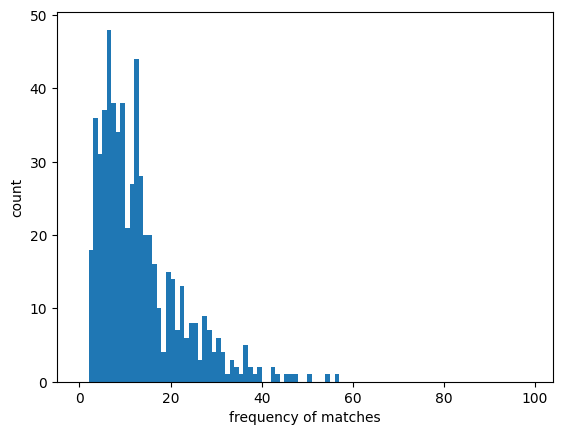

In [13]:
# plt.hist(match_count, bins = range(min(match_count),max(match_count)+1))
plt.hist(match_count, bins = range(0,100))
plt.xlabel('frequency of matches'), plt.ylabel('count')
plt.show()

- The majority of contigs contain few (<20) matches - as expected, since most contigs are fairly short (<300) (see below).

Thus we must consider the location of matches, not just matches alone. Naturally, this leads to the idea of a 'neighbourhood' - the question is, how do we define this?

## Investigating the correlation between matches in one contig to other matches in its neighbourhood:

### The idea:
Represent the matches and non-matches in a contig by 1s and 0s respectively.

Define close and far: 
- Two matches are "far apart" if they are $\geq M$, and "close"/"connected" if $\leq N$ apart. 
- Notion of closeness is quantified using a measure of distance/dissimilarity $d(x,y)$; may need to take into account position, distance from ends, length of PUL, etc. We'll start by just taking the Euclidean distance (e.g. '11' is distance 1)

Define "cluster":
- Fix $N$.  If $d(a,c) < N$, connect $E(a,b)$. The cluster is the closure of edges $E$.

Look for clusters:
- Instead of looking at a fixed neighbourhood and then identifying matches within the neighbourhood, we will treat neighbourhoods as transitive, and consider a cluster as the number (or some metric that considers the number) of connected matches.

Analyse clusters:
- Number of clusters in each PUL, distance between clusters, length/radius, number of matches in each cluster (=size), mean & maximum cluster size, 
- Within each cluster: number of matches, distance between matches
- Alter $N$, $M$ accordingly

In [14]:
contig_ids = [] #contains list of contig IDs
for x in subcat:
    x_cat = x[0].split('_')[0]
    contig_ids.append(x_cat)

In [15]:
flat_subcat = [] #flatten subcat into one list, for constructing matches_01 below
for x in subcat:
    flat_subcat.extend(x)

For each contig, `matches_01` stores the corresponding list of 0s and 1s, shown below:

In [16]:
matches_01 = []
for x in range(len(subcat)): #append N empty lists to matches_01
    matches_01.append([])

# matches_01 = [[] for x in subcat]
print('1 ok')

num_array = [int(y.split('_')[1]) for y in id_list] #orf numbers
id_count_rev = [y.split('_')[0] for y in id_list]
id_count_rev = id_count_rev[::-1] #since index only takes the first occurrence
max_orf = []
for x in contig_ids:
    ind = len(id_count_rev)-1 - id_count_rev.index(x)
    max_orf.append(num_array[ind])

for i in range(len(max_orf)):
    for j in range(max_orf[i]):
        matches_01[i].append(0)

print('2 ok')

for x in flat_subcat: #use list of matches instead (flat_subcat)
    x1 = x.split('_')
    index=contig_ids.index(x1[0])
    if int(x1[1]) > len(matches_01[index]):
        matches_01[index].extend(np.ones(int(x1[1]) - len(matches_01[index]),))
    else:
        matches_01[index][int(x1[1])-1] = 1 #insert 1 if a match  

# takes ~3 min
# '1 ok': ~1 s
# '2 ok': ~2 min
# remember that contig ids count from 1, python indexing counts from 0

1 ok
2 ok


A check: sum of `testarray` below is zero, so `matches_01` is correct according to our diamond output (assuming that no matches have been missed out)

In [17]:
b = [len(matches_01[i]) for i in range(len(matches_01))]
testarray=np.array(b) - np.array(max_orf)
sum(testarray)

0

Another check: (to make sure contig_ids and id_count_array lists the contig ids in the same order) array of sum of number of matches recorded in each contig in `matches_01` should be equal to that of `subcat`:

In [18]:
sum_matches_array = [sum(matches_01[i]) for i in range(len(matches_01))]
sum_subcat = [len(subcat[i]) for i in range(len(subcat))]
sum_subcat == sum_matches_array

True

### 1. Computing the number of matches in each contig:


In [19]:
# temparray=[]
# max_ind_array = []
# for x in subcat:
#     temparray = [int(y.split('_')[1]) for y in x]
#     max_ind_array.append(max(temparray))

In [20]:
len_matches_array = [len(matches_01[i]) for i in range(len(matches_01))]

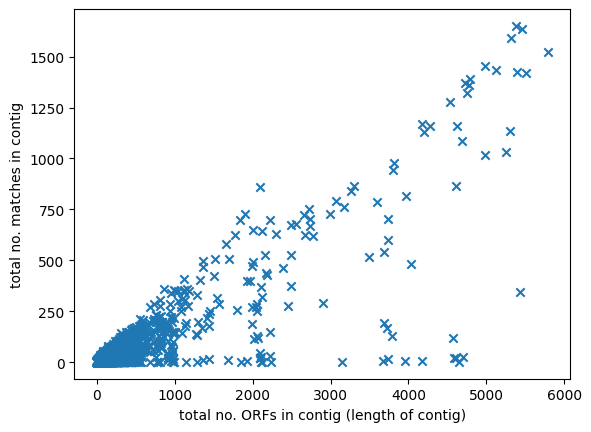

In [21]:
plt.scatter(len_matches_array, sum_matches_array,marker='x')
plt.xlabel('total no. ORFs in contig (length of contig)')
plt.ylabel('total no. matches in contig')
plt.show()

- Total no. matches is roughly proportional to contig length (for contigs of length > 1000), with some contigs having very few (<50) matches regardless of length

### 2. Program to count no. clusters & cluster size in each contig:

Result: we will have the following information:
- Length of contig (ie total number of ORFs in contig)
- No. matches (1s) / non-matches (0s)
- No. clusters
- A list of cluster sizes for each contig

<!-- Drawback: this may not differentiate between e.g. a contig containing clusters all of a consistent medium size vs a contig containing one large cluster and remaining small ones. -->

<!-- Solution: count cluster size -->



In [23]:
# no. clusters = no. subseqs of 0 of length >= N+1 (or +1 if seq starts and ends with 1s, or -1 if seq starts and ends with 0s). call these anti-clusters
def clustercount(N,contig,sizeflag): #N is int, contig is array or list of matches (1s and 0s only), [sizeflag is boolean]
    count = 0 # no. clusters
    size = [] #size of clusters
    indstore = [] #for storing indexes to keep track of clusters for measuring size. index of any zero between clusters
    flag = False #for indicating whether to append to indstore on next loop (or not)
    if sum(contig) == len(contig): # ie all 1s
        count = 1
        size.append(sum(contig))
    else:
        start = contig.index(0)
        ind = start
        indstore.append(0)
        if sum(contig[0:ind]) > 0: indstore.append(ind) #, indstore.append(0) #indstore will start and end with 0

        temp = contig[:]
        temp.extend([1 for i in range(N)]), temp.append(0)

        #flag: 0=at a zero, in between clusters, already recorded
        #      1=at a zero, within a cluster
        #      2=at a zero, in between clusters, not yet recorded.
        while ind in range(start,len(contig)):
            if sum(temp[ind:ind+N]) == 0:
                oldind=ind
                if flag: indstore.append(ind) #ie immediately after the end of a cluster/before start of cluster
                count +=1 #syntax? #register one cluster
                ind = temp[ind+N:].index(1) + ind+N #finds first 1 following the 0
                ind = temp[ind+1:].index(0) + ind+1 #finds first 0 following the 1
                if sum(temp[oldind:ind])>0: #ie either after cluster or within cluster
                    if sum(temp[ind:ind+N]) == 0: #ie after cluster
                        flag=True
                    else:
                        flag=False
            else:
                if flag: indstore.append(ind) #contig[ind]=0 at this point; immediately before the start of a cluster & not yet recorded
                oldind=ind
                ind = temp[ind+1:].index(1) + ind+1 #finds next 1
                ind = temp[ind+1:].index(0) + ind+1 #finds first 0 following the 1
                if sum(temp[oldind:ind])>0: #ie either after cluster or within cluster
                    if sum(temp[ind:ind+N]) == 0: #ie after cluster
                        flag=True
                    else:
                        flag=False
        if sum(temp[0:N]) > 0 and sum(temp[-2*N -1:-N-1]) > 0: # ie seq starts & ends with clusters
            count +=1
        elif sum(temp[0:N]) == 0 and sum(temp[-2*N -1:-N-1]) == 0: #ie seq starts & ends with anticlusters
            count -=1
        elif count == 0 and sum(contig) > 0: #account for fact that this func only counts anticontigs
            count +=1
        indstore.append(len(contig))
        indstore = list(dict.fromkeys(indstore))
        for i in range(len(indstore)-1):
            ind1 = indstore[i]
            ind2 = indstore[i+1]
            size.append(sum(contig[ind1:ind2]))
    size = [x for x in size if x != 0] #remove zeros
    if sizeflag: return size
    if not sizeflag: return count

#eg: '11' is distance 1;


In [24]:
k=0
n=3
contig=matches_01[k][:]
print('contig: ',k,' ',contig_ids[k])
print('length of contig: ', len(matches_01[k]))
print('no. matches: ', sum(matches_01[k]))
print('no. clusters: ', clustercount(n,contig,False))
#can also add dist of sizes of clusters?


contig:  0   accn|CP129981
length of contig:  5457
no. matches:  1634
no. clusters:  485


Construct Dataframe to store cluster data:

In [34]:
a=contig_ids
b=[] #contig length
c=[] #no. matches
d,e,f,g,h=[],[],[],[],[] #no. clusters, for fixed N
N=[1, 2, 3, 5, 10]
# N=2
for i in range(len(contig_ids)):
    b.append(len(matches_01[i]))
    c.append(sum(matches_01[i]))
    d.append(clustercount(N[0],matches_01[i][:],False)), e.append(clustercount(N[1],matches_01[i][:],False)), f.append(clustercount(N[2],matches_01[i][:],False)), g.append(clustercount(N[3],matches_01[i][:],False)), h.append(clustercount(N[4],matches_01[i][:],False))

meansize_2 = [mean(clustercount(2,matches_01[i],True)) for i in range(len(matches_01))]
meansize_3 = [mean(clustercount(3,matches_01[i],True)) for i in range(len(matches_01))]
meansize_5 = [mean(clustercount(5,matches_01[i],True)) for i in range(len(matches_01))]

data = {'contig id': a,
        'contig length': b,
        'no. matches': c,
        'mean cluster size, N=2': meansize_2,
        'mean cluster size, N=3': meansize_3,
        'mean cluster size, N=5': meansize_5,
        'no. clusters, N='+str(N[0]): d,
        'no. clusters, N='+str(N[1]): e,
        'no. clusters, N='+str(N[2]): f,
        'no. clusters, N='+str(N[3]): g,
        'no. clusters, N='+str(N[3]): h}
cluster_df = pd.DataFrame(data)

In [26]:
cluster_df

contig id  contig length  no. matches  \
0             accn|CP129981           5457         1634   
1      accn|JAUKNU010000001           5790         1522   
2             accn|CP128558           5312         1592   
3             accn|CP128508           5515         1422   
4      accn|JAUDEV010000001           5429          346   
...                     ...            ...          ...   
19322  accn|CASUGI010000248              3            1   
19323  accn|JAKEBI010000359              3            1   
19324  accn|JAUNNL010000200              1            1   
19325  accn|JAKDRO010000283              1            1   
19326  accn|JAUDZE010000025              2            1   

       mean cluster size, N=2  mean cluster size, N=3  mean cluster size, N=5  \
0                    2.569182                3.369072                5.713287   
1                    2.087791                2.813309                4.570571   
2                    2.531002                3.401709                5.831502   
3                    2.331148                2.962500                4.755853   
4                    1.544643                1.774359                2.084337   
...                       ...                     ...                     ...   
19322                1.000000                1.000000                1.000000   
19323                1.000000                1.000000                1.000000   
19324                1.000000                1.000000                1.000000   
19325                1.000000                1.000000                1.000000   
19326                1.000000                1.000000                1.000000   

       no. clusters, N=1  no. clusters, N=2  no. clusters, N=3  \
0                    899                636                485   
1                   1011                729                541   
2                    900                629                468   
3                    841                610                480   
4                    253                224                195   
...                  ...                ...                ...   
19322                  1                  1                  1   
19323                  1                  1                  1   
19324                  1                  1                  1   
19325                  1                  1                  1   
19326                  1                  1                  1   

       no. clusters, N=5  
0                     72  
1                    101  
2                     81  
3                    108  
4                    101  
...                  ...  
19322                  1  
19323                  1  
19324                  1  
19325                  1  
19326                  1  

[19327 rows x 10 columns]

In [32]:
k=19096
contig = matches_01[k][:]
X, y = [], []
X.append(0), y.append(sum(matches_01[k]))
for n in range(1,100):
    y.append(clustercount(n,contig,False))
    X.append(n)

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(X,y, label='original')
plt.xlabel('N')
plt.ylabel('no. clusters')
plt.title('no. clusters vs N')

y_new = [np.exp(-a) for a in y]
# y_new = [1/a for a in y]
plt.subplot(1,2,2)
plt.plot(X,y_new, label='new')
plt.xlabel('N')
plt.ylabel('no. clusters')
plt.title('exp(-no. clusters) vs N')

plt.show()

The first plot above displays the number of clusters against N; in the second plot we try to alter the y-values of the first plot to find the type of curve it is (e.g. logarithmic, polynomial, exponential)

### Overlaying the above for different contigs:

In [33]:
# lst = range(10) #or randsample from range(len(matches_01))?
lst = random.sample(range(len(matches_01)),10)
X, y = [], []

for i in range(len(lst)):
    contig = matches_01[lst[i]][:]
    X.append([]), y.append([])
    X[i].append(0), y[i].append(sum(matches_01[lst[i]]))
    for n in range(1,100):
        y[i].append(clustercount(n,contig,False)), X[i].append(n)
    plt.plot(X[i],y[i], label=str(lst[i])+' '+contig_ids[i]) #str(lst[[i]]))

    # plt.plot(X,y)
plt.legend(loc='upper right')
plt.xlabel('N')
plt.ylabel('no. clusters')
plt.show()

Note:
- single straight line through 1 (e.g. k=7000) represents one match in whole contig 
- downward step function at x (e.g. k=1000) suggests one cluster is of size x 
- negative exponential(?) (e.g. k=1,10) cluster sizes are evenly distributed?
    - k=10: looks like logarithmic/exponential - but disproved using plot above..

Histogram of no. clusters in each contig:

In [29]:
X=[]
n=3
for k in range(len(matches_01)):
    X.append(clustercount(n,matches_01[k],False))

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.hist(X, bins=range(max(X)+1))
plt.ylim(0,3000)
plt.xlabel('no. clusters')
plt.ylabel('freq')
plt.title('Number of clusters in each contig, N='+str(n))

plt.subplot(1,2,2)
plt.hist(X, bins=range(max(X)+1))
plt.yscale('log')
# plt.ylim(0,3000)
plt.xlabel('no. clusters')
plt.ylabel('freq')
plt.title('Number of clusters in each contig, N='+str(n))

plt.show()

- Majority of contigs have few (<10) clusters - this may appear to suggest that distribution of matches within each contig is not random and there may be some clustering effect, but when considering that contig lengths are mostly short (<300) [see plot below], it is worth investigating further.
- Cluster count alone does not provide enough information; we will also consider cluster sizes.

In [30]:
matchlen = [len(matches_01[i]) for i in range(len(matches_01))]
plt.hist(matchlen, bins=range(max(matchlen)+1), log='True')
plt.xlabel('contig length'), plt.ylabel('freq')
plt.title('Histogram of contig lengths')
plt.show()

In [35]:
#plot of matches & clusters vs contig length:
plt.figure(figsize=(20, 8))
i=2 #N

plt.subplot(1,2,1)
plt.scatter(cluster_df.iloc[:,1], cluster_df.iloc[:,2], marker='x', label='no. matches',color='green')
plt.ylim(0,1700)
plt.title('no. matches vs contig length')
plt.xlabel('contig length'), plt.ylabel('matches count')

plt.subplot(1,2,2)
plt.scatter(cluster_df.iloc[:,1], cluster_df.iloc[:,5+i], marker='x', label='no. clusters, N='+str(N[i]),color='purple')
plt.ylim(0,1700)
plt.title('no. clusters vs contig length, for N='+str(N[i]))
plt.xlabel('contig length'), plt.ylabel('cluster count')

# plt.legend(loc='upper left')
plt.show()

From the plot above (matches & clusters vs contig length, for N=3):
- Dense for contig length 0-1000 (see histogram below)
- Both dependent variables show some positive correlation with contig length, approx linearly proportional
- A number of contigs with very few clusters but many more matches - (good), suggests there may be corr between contig 
    - score and exclude 'bad' contigs using some theshold? eg $s = \frac{\text{no. matches}}{\text{no. clusters}}\ <\ x$,  for e.g. $x=\frac{1}{3}$ (see below)
    - Here, $s$ is mean cluster size.
    - This could be improved by making the score dependent on $N$, $M$, or contig size, etc
    
$\\$
- As N is increased, the second plot becomes less steep - as expected, since separate clusters will eventually become grouped into one 
    

In [ ]:
cluster_df

contig id  contig length  no. matches  \
0             accn|CP129981           5457         1634   
1      accn|JAUKNU010000001           5790         1522   
2             accn|CP128558           5312         1592   
3             accn|CP128508           5515         1422   
4      accn|JAUDEV010000001           5429          346   
...                     ...            ...          ...   
19322  accn|CASUGI010000248              3            1   
19323  accn|JAKEBI010000359              3            1   
19324  accn|JAUNNL010000200              1            1   
19325  accn|JAKDRO010000283              1            1   
19326  accn|JAUDZE010000025              2            1   

       mean cluster size, N=2  mean cluster size, N=3  mean cluster size, N=5  \
0                    2.569182                3.369072                5.713287   
1                    2.087791                2.813309                4.570571   
2                    2.531002                3.401709                5.831502   
3                    2.331148                2.962500                4.755853   
4                    1.544643                1.774359                2.084337   
...                       ...                     ...                     ...   
19322                1.000000                1.000000                1.000000   
19323                1.000000                1.000000                1.000000   
19324                1.000000                1.000000                1.000000   
19325                1.000000                1.000000                1.000000   
19326                1.000000                1.000000                1.000000   

       no. clusters, N=1  no. clusters, N=2  no. clusters, N=3  \
0                    899                636                485   
1                   1011                729                541   
2                    900                629                468   
3                    841                610                480   
4                    253                224                195   
...                  ...                ...                ...   
19322                  1                  1                  1   
19323                  1                  1                  1   
19324                  1                  1                  1   
19325                  1                  1                  1   
19326                  1                  1                  1   

       no. clusters, N=5  
0                     72  
1                    101  
2                     81  
3                    108  
4                    101  
...                  ...  
19322                  1  
19323                  1  
19324                  1  
19325                  1  
19326                  1  

[19327 rows x 10 columns]

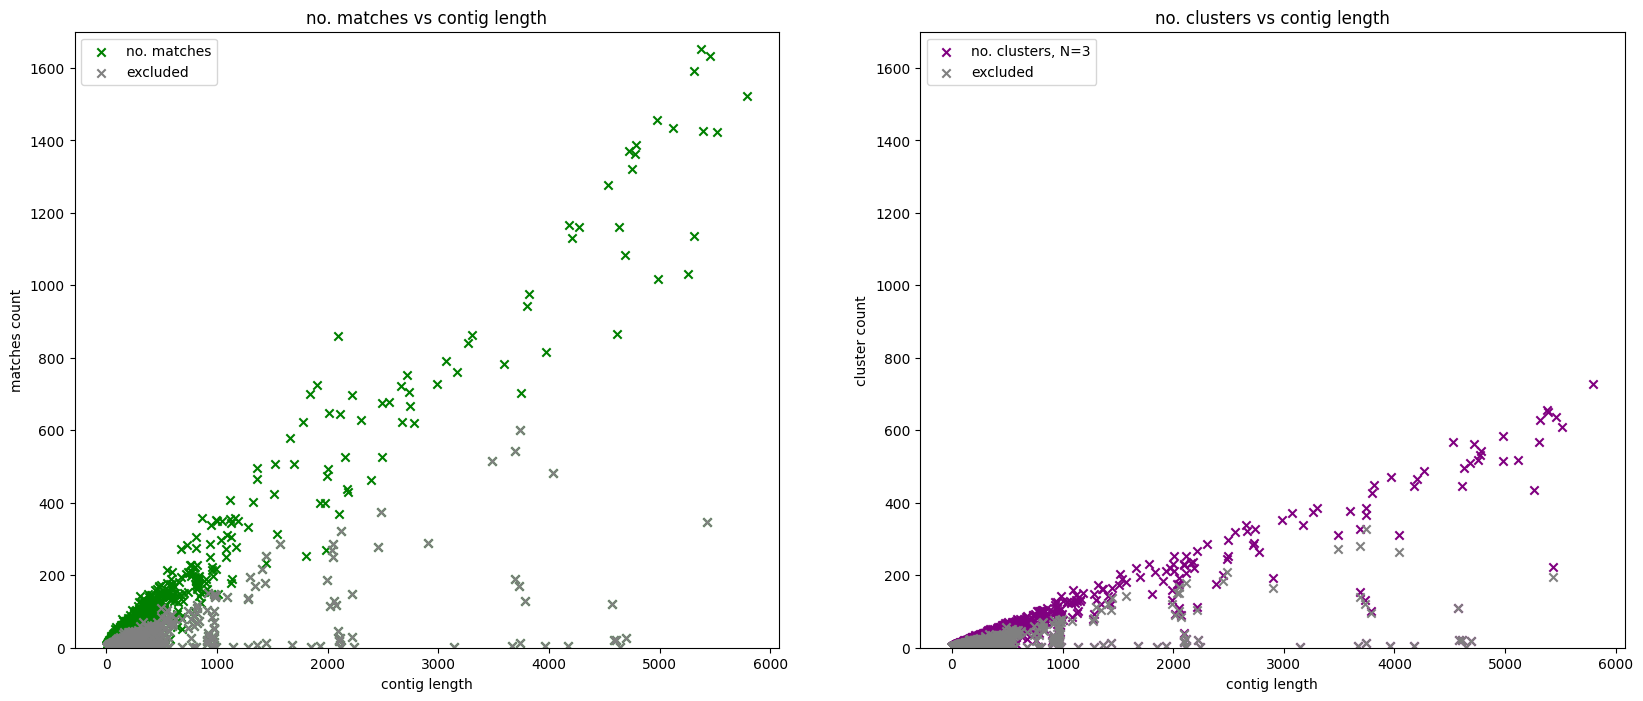

In [46]:
n=2 #value between 0-3

excl=[[],[],[]]
excl_ind=[]
l=cluster_df.iloc[:,1] #length
m=cluster_df.iloc[:,2]
c=cluster_df.iloc[:,8]
for i in range(len(contig_ids)):
    # print('score = ',(m[i]-c[i])/m[i],'_', 'contig len = ',l[i],' ', 'matches = ',m[i],' ', 'clusters = ', c[i])
    if m[i]/c[i] < 2:    #(m[i]-c[i])/m[i] < 1/3:
        excl[0].append(l[i]), excl[1].append(m[i]), excl[2].append(c[i])
        excl_ind.append(1)
    else:
        excl_ind.append(0)

plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
plt.scatter(cluster_df.iloc[:,1], cluster_df.iloc[:,2], marker='x', label='no. matches',color='green')
plt.scatter(excl[0],excl[1],marker='x',color='gray',label='excluded')
plt.ylim(0,1700)
plt.title('no. matches vs contig length')
plt.legend(loc='upper left')
plt.xlabel('contig length'), plt.ylabel('matches count')

plt.subplot(1,2,2)
plt.scatter(cluster_df.iloc[:,1], cluster_df.iloc[:,5+n], marker='x', label='no. clusters, N='+str(N[n]),color='purple')
plt.scatter(excl[0],excl[2],marker='x',color='gray',label='excluded')
plt.ylim(0,1700)
plt.title('no. clusters vs contig length')
plt.legend(loc='upper left')
plt.xlabel('contig length'), plt.ylabel('cluster count')

# plt.legend(loc='upper left')
plt.show()

In [44]:
cluster_df['excl']=excl_ind #1 if excluded; 0 otherwise

- Plot above excludes contigs which have mean cluster size less than 2. This was ~62% of the database.
- Remaining contigs follow a roughly linear relationship between match count & contig length, and cluster count & contig length.

A histogram of $\frac{1}{\text{mean cluster size}}$ vs contig length is shown below. There are few contigs with low (<0.2) scores, and most contigs lie within 0.3-0.6.

In [64]:
plt.figure(figsize=(7,5))
fig, ax = plt.subplots()
cluster_frac=[]
cluster_frac=[cluster_df.iloc[i,8]/cluster_df.iloc[i,2] for i in range(len(contig_ids))]
cluster_frac1 = [1/a for a in cluster_frac]
counts, xedges, yedges, im = ax.hist2d(cluster_df.iloc[:,1], cluster_frac, bins=10, range=[[0,1000], [0,1]], norm=LogNorm())#, norm=LogNorm(), range=[[0,1.2],[-800,0]])
fig.colorbar(im)
ax.set_facecolor((0, 0, 0))

plt.xlabel('contig length'), plt.ylabel('[no. clusters/no matches]^-1')
plt.show()


<Figure size 700x500 with 0 Axes>

## Cluster Size

Size of a cluster is defined by the number of matches within the cluster

Histogram of sizes of clusters:
- First plot displays cluster size distribution for a chosen contig
- Second plot below displays distribution of cluster size aggregated over all contigs


Text(0.5, 1.0, 'distribution of cluster size (N=2) for contig 10')

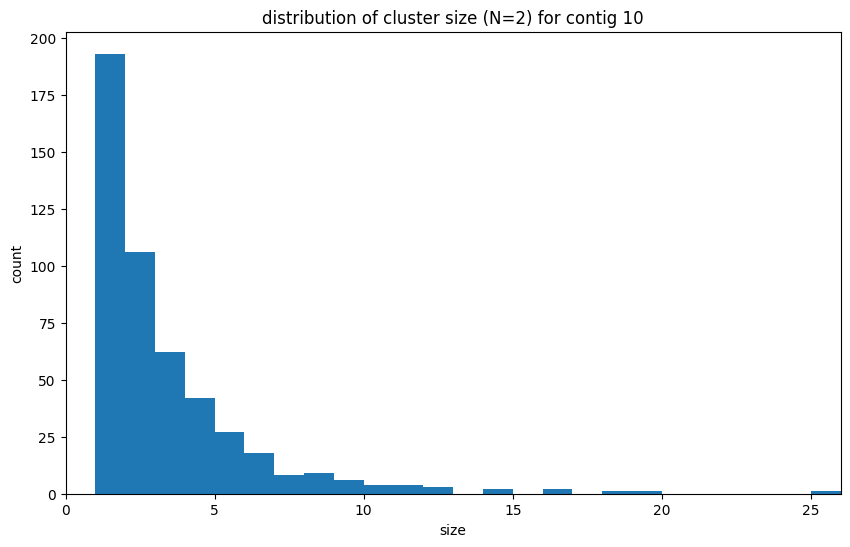

In [ ]:
k=10
N=3
contig = matches_01[k][:]
x=[]
plt.figure(figsize=(10,6))


x = clustercount(N,matches_01[k],True)
plt.hist(x, bins=range(max(x)+1))
#np.arange?
plt.xlabel('size')
plt.ylabel('count') #define size??
plt.xlim([0,max(x)])
plt.title('distribution of cluster size (N=2) for contig '+str(k)) #also consider cluster size vs N??


Consider a logarithmic transformation of the y-axis (count) as shown below; the resulting histogram is roughly linearly decreasing in count - this may suggest that the contig sizes are geometrically distributed?

In [ ]:
N=3
x=[]
for k in range(len(matches_01)):
    x.extend(clustercount(N,matches_01[k],True))

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.hist(x, bins=range(max(x)+1))
plt.xlabel('size')
plt.ylabel('count')
plt.title('distribution of cluster size (N=2) over all contigs')

plt.subplot(1,2,2)
plt.hist(x, bins=range(max(x)+1))
plt.yscale('log')
plt.xlabel('size')
plt.ylabel('count')
plt.title('distribution of cluster size over all contigs with log y scale')

plt.show()

- Smaller cluster sizes are more frequent, but we must also consider that there are many clusters of short (<300) length - this does not provide enough information about the distribution of clusters in each contig, so we consider a plot of cluster count vs mean cluster size:

### Scatter plot of no. clusters vs average cluster size:

In [ ]:
N=3
X=[]
y=[]
for k in range(len(matches_01)):
    X.append(mean(clustercount(N,matches_01[k],True))) #avg cluster size for each contig
    y.append(clustercount(N,matches_01[k],False))

plt.figure(figsize=(10, 10))
plt.scatter(X,y,marker='x')
plt.xlabel('mean cluster size')
plt.ylabel('no. clusters')
plt.title('Plot of no. clusters vs average cluster size, for N = '+str(N))

plt.show()

Same scatter plot of mean cluster size vs contig length (N=3), but coloured by no. matches:

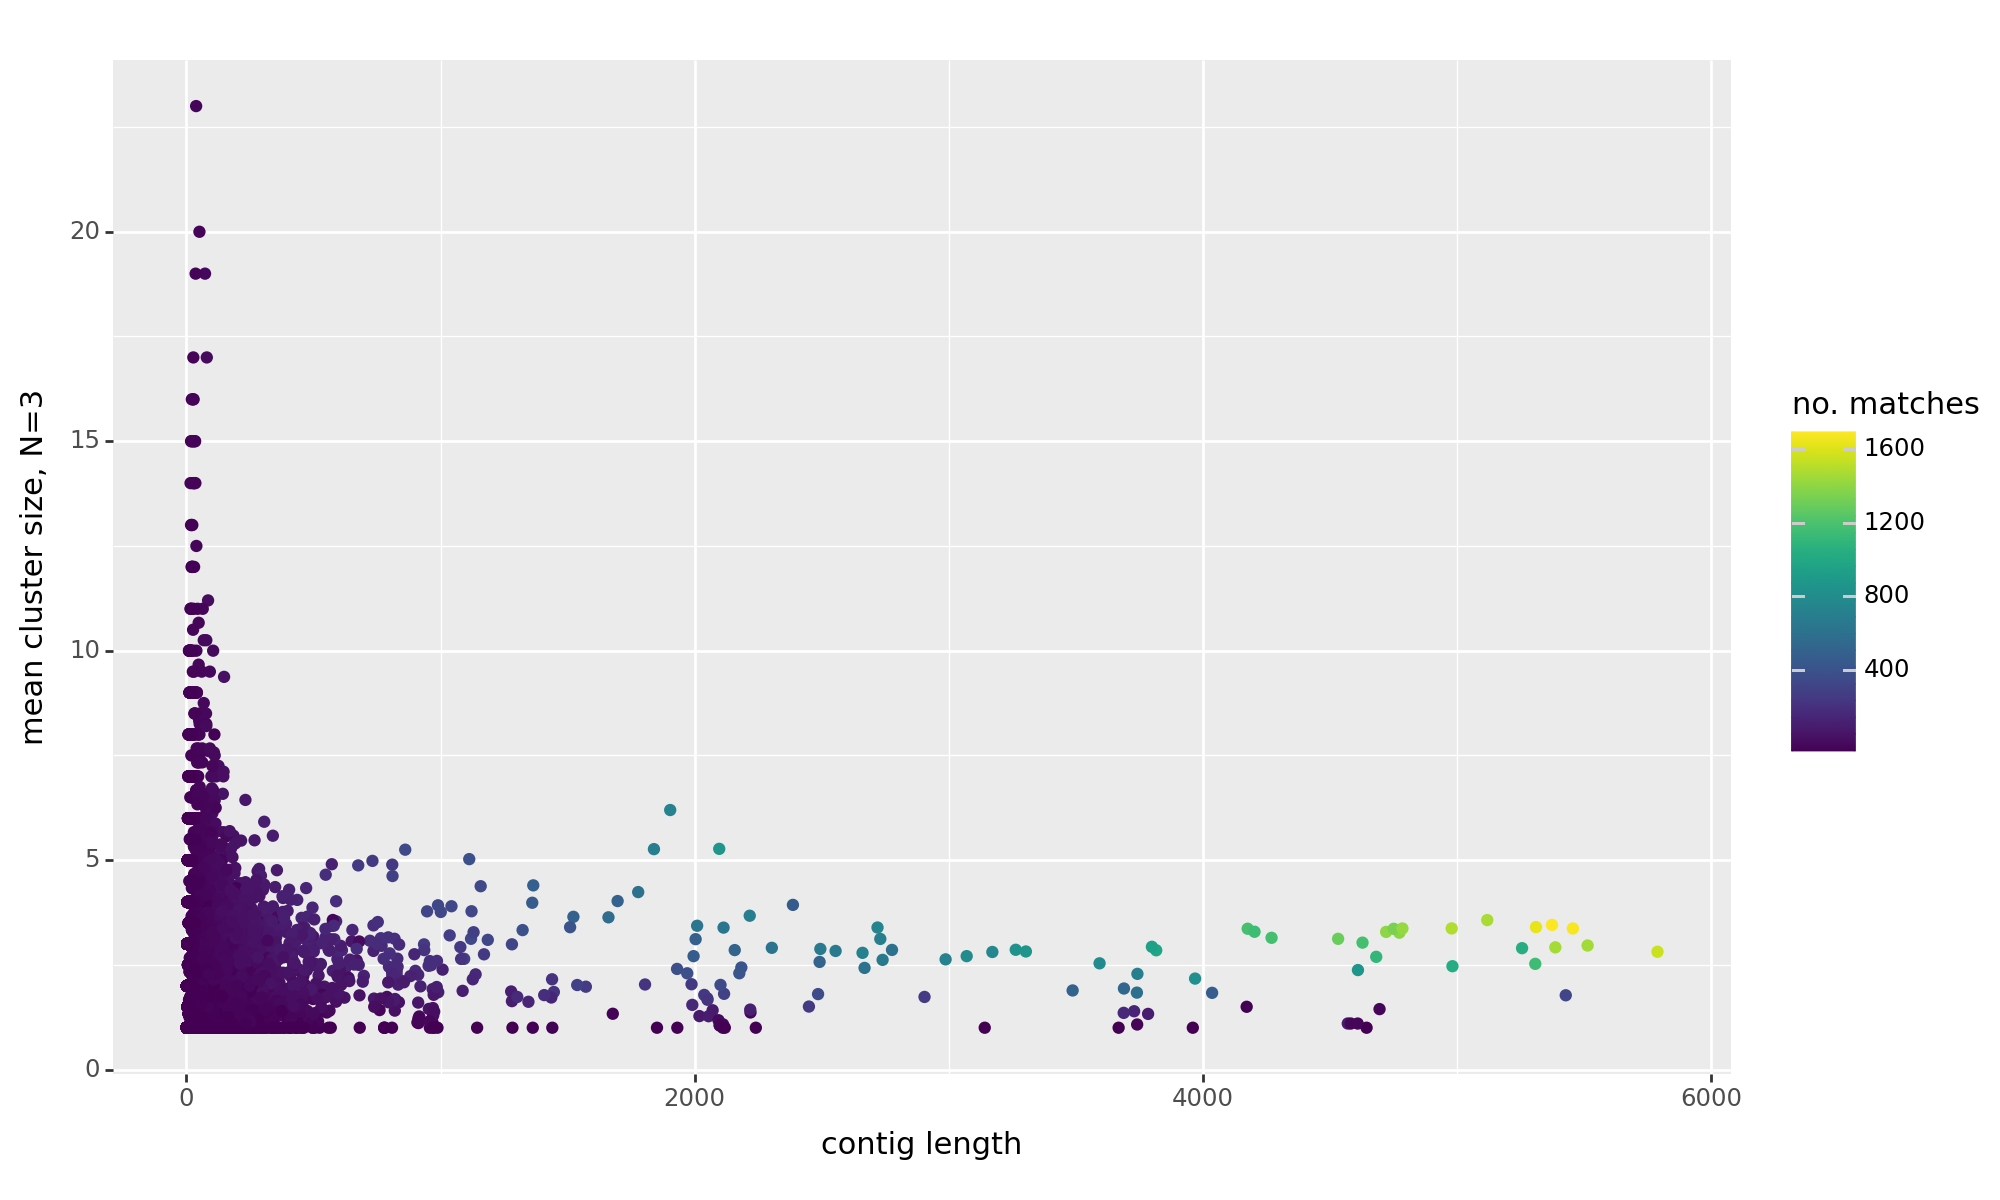

<Figure Size: (1000 x 600)>

In [ ]:
#plot of mean cluster size vs contig length, coloured by no. matches:
(
    ggplot(cluster_df,aes(x='contig length', y='mean cluster size, N=3', color='no. matches')) + geom_point() + theme(figure_size=(10,6))
)

**Observations:**

Majority of contigs are of small (<4) mean cluster size, independent of increasing contig length or number of matches.
- Contigs with fewer matches tend to have lower mean cluster size - as expected.
- Many contigs with low no. matches and low contig length (see below for histogram, as density is not clear here)
    - Mean cluster sizes of these contigs are mostly low (<4) as expected, due to few matches
    - Some have a larger (>4) number of clusters - this could just be due to natural variation in cluster distribution, or some aspect of these contigs (eg taxa) may cause matches to be more spread out/clusters less likely to form.
- Contigs with large no. matches (>1200) are mostly of large length and have short mean cluster length (between 2-3).

Suggests there may be some clustering effect; the matches may not be randomly distributed!

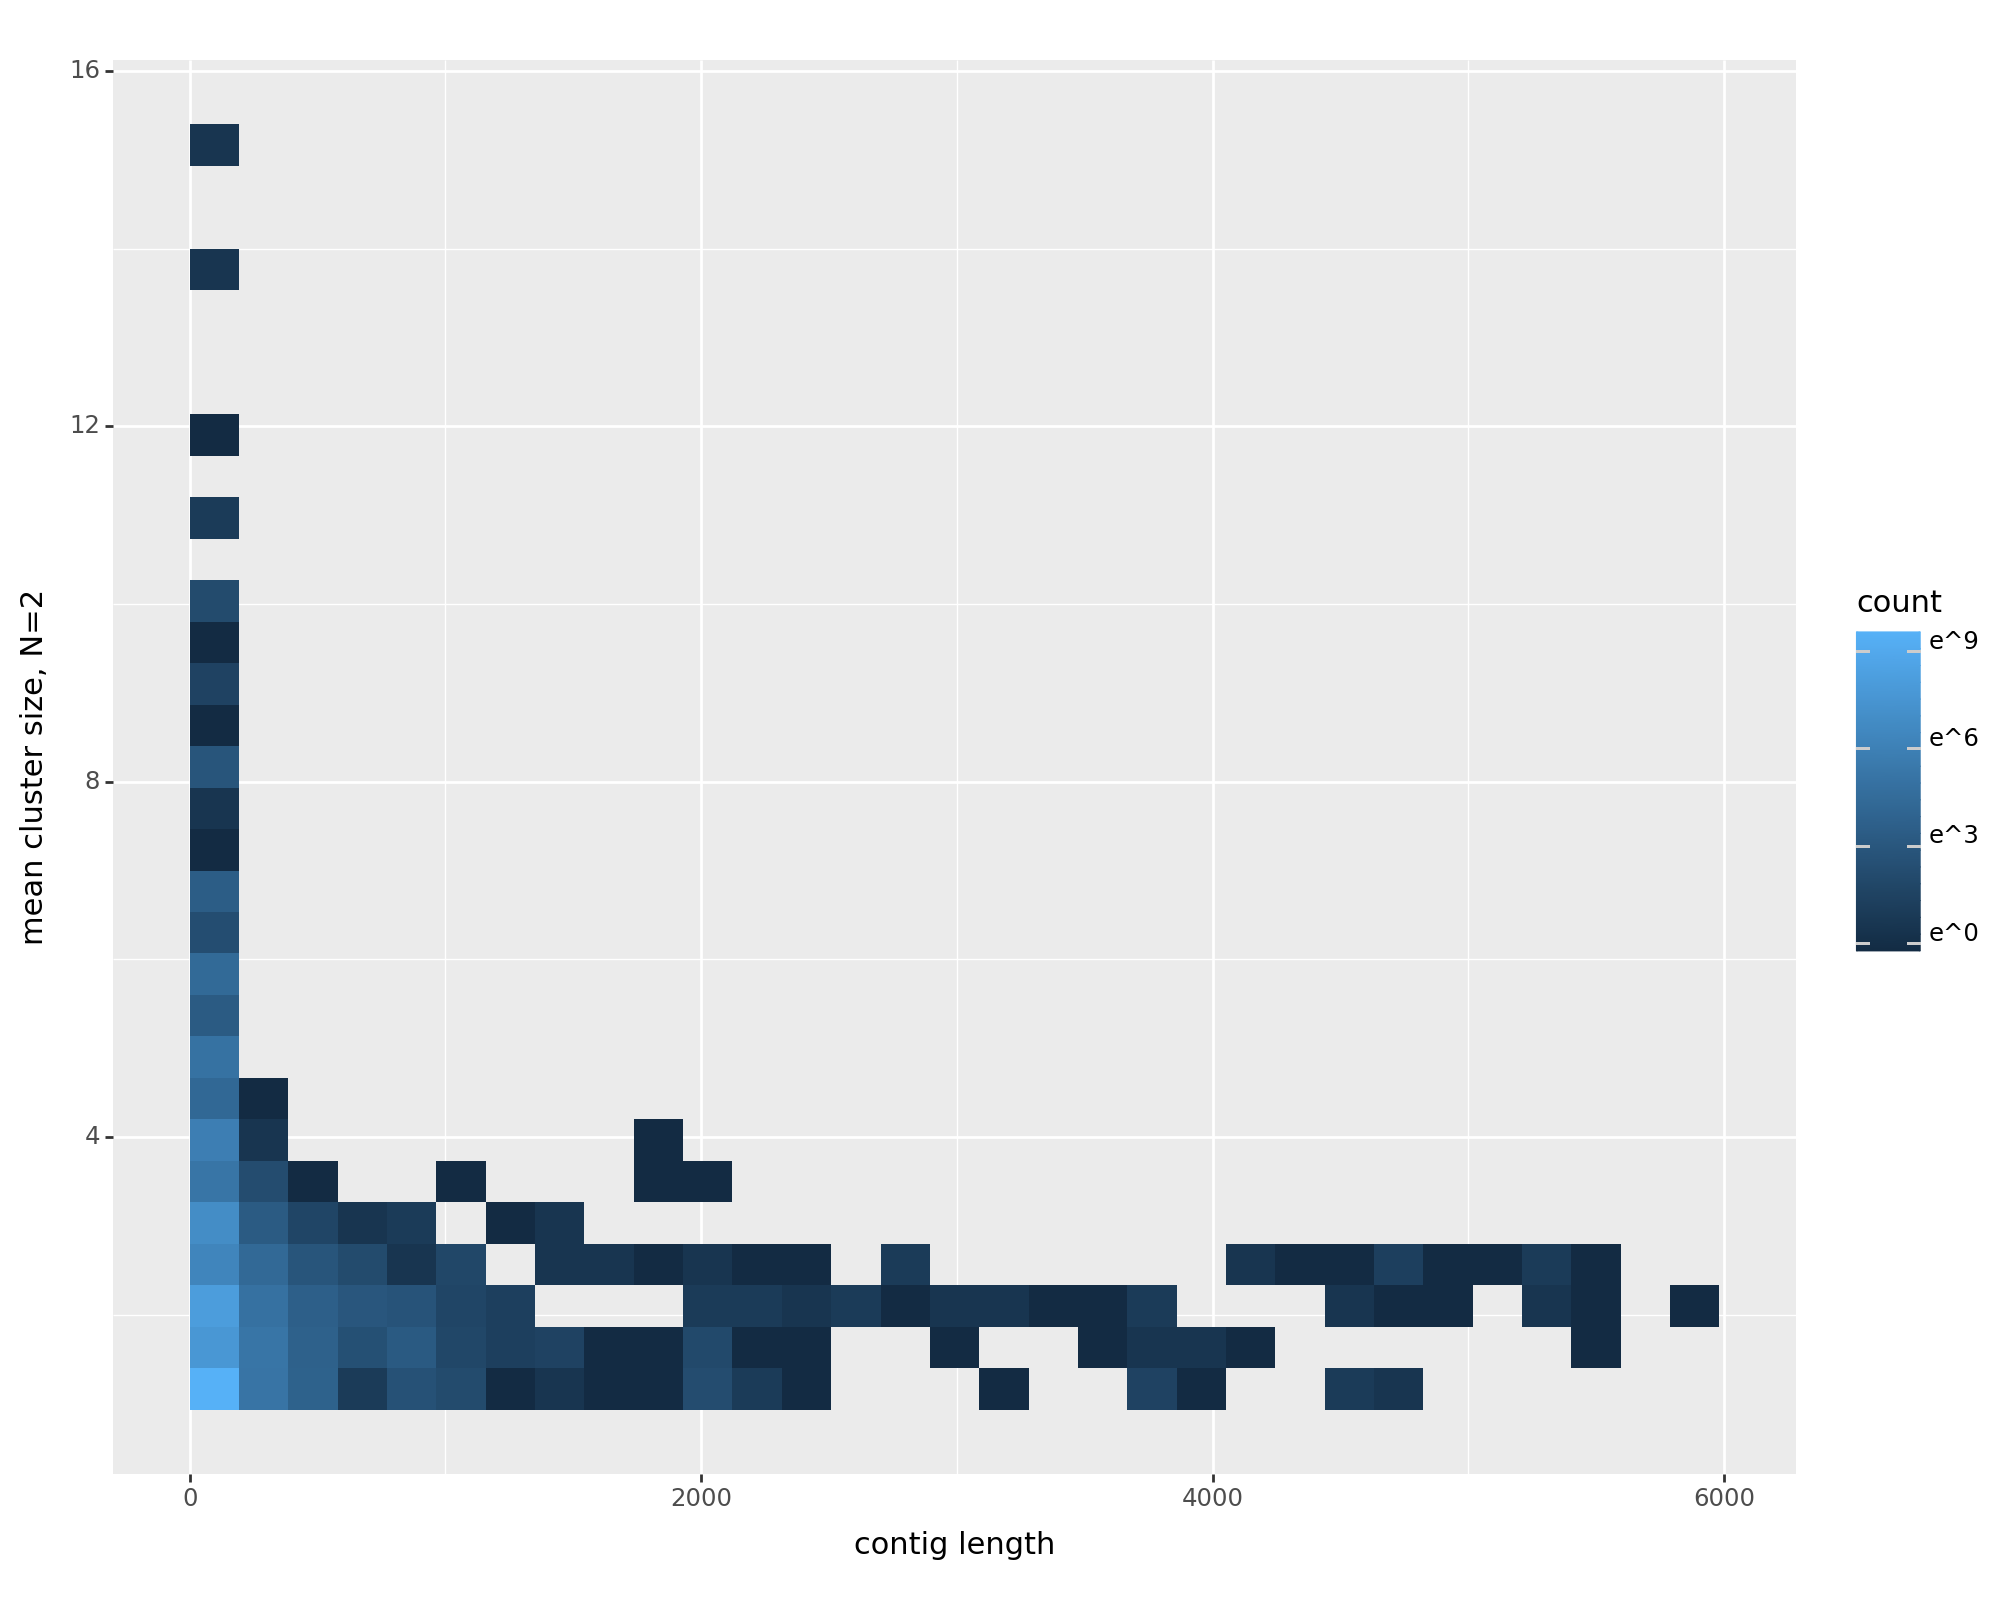

<Figure Size: (1000 x 800)>

In [ ]:
#same as above, but histogram used instead of scatter plot
(
    ggplot(cluster_df,aes(x='contig length', y='mean cluster size, N=2', color='no. matches'))
    + geom_bin2d()
    + scale_fill_gradient(name = "count", trans = "log") # breaks = my_breaks, labels = my_breaks)
    + theme(figure_size=(10, 8))
)

### [Aggregating the clusters across all contigs:]

In [ ]:
clustersize=[]
for x in matches_01:
    clustersize.extend(clustercount(2,x,True))


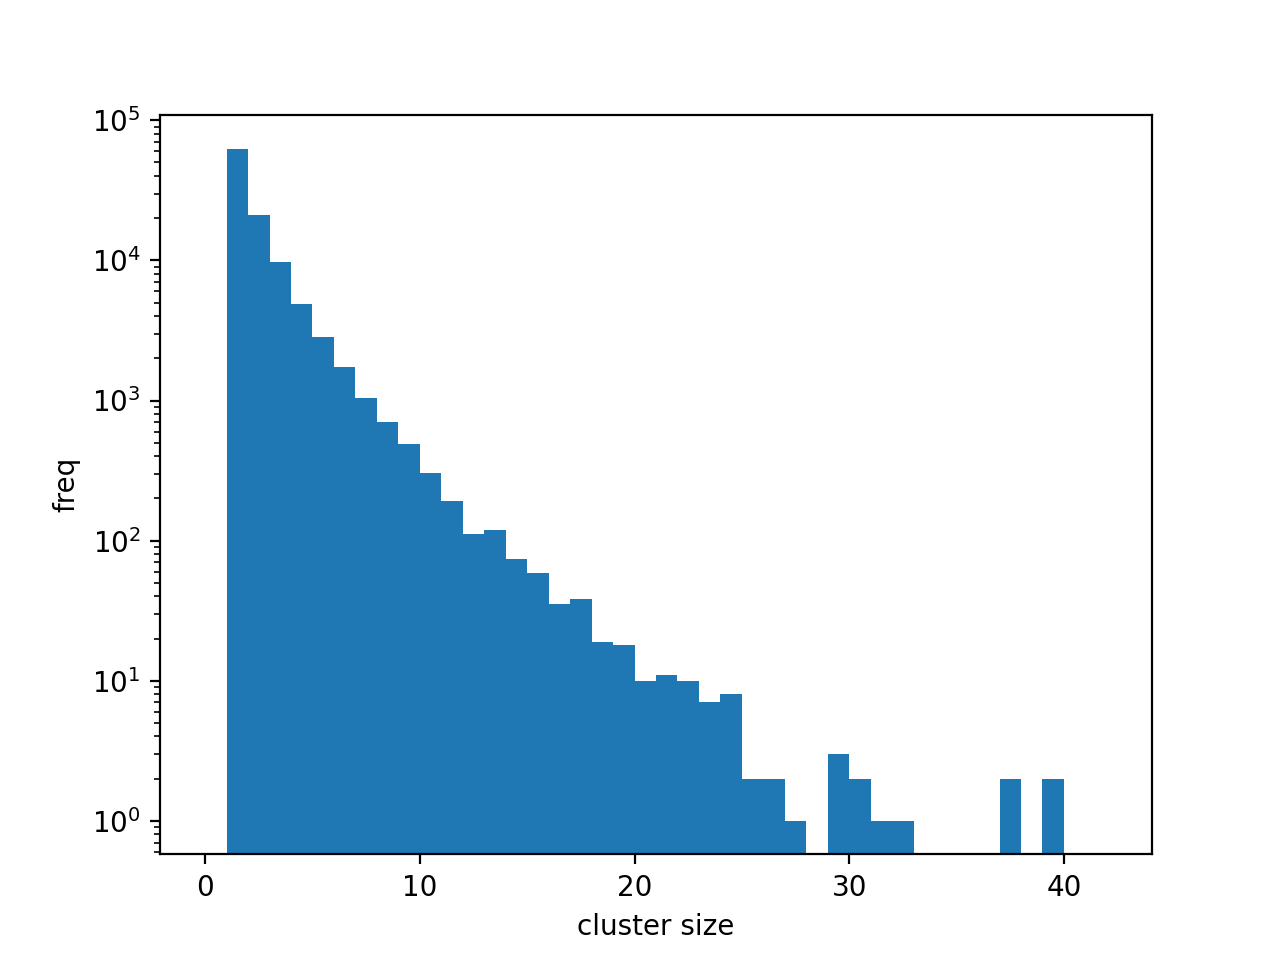

In [ ]:
m=int(np.ceil(max(clustersize)))
plt.hist(clustersize, bins=range(m), log=True) #, range=(0,10)) #bins=range(m))
ax = plt.gca()
# ax.set_xlim([0,10])
# ax.set_ylim([0,80])
plt.xlabel('cluster size')
plt.ylabel('freq')
plt.show()

#~12 mins

Roughly linear on a log scale - looks like geometric distribution?

## Hypothesis test:

We will test if the matches in each contig are randomly assigned, or not.

**Null hypothesis:** matches are randomly assigned. We will test this using a Monte Carlo method:
- For each contig, randomly generate a large number of random sequences with the same length and same number of 1s & 0s (matches).
- Plot the null in a histogram counting the mean cluster size
- Find p-value of chosen contig, using our histogram
- Repeat; then we will plot histogram of p-values for each contig

`pval` is a function that takes contig (and N & no. of random samples) as input and outputs p value:

In [66]:
# outputs p-value (+histogram) for mean cluster size (+ try max cluster size, no. clusters rel to contig length, etc)
# infoFlag (boolean) toggles if output displays extra information (eg graph,input contig mean cluster size, etc)
def pval(contig,N,samplesize,binwidth,infoFlag):
    clusters=[]
    ones=sum(contig)
    l=len(contig)
    sample=np.zeros((samplesize,l))
    sample[:,0:ones]=np.ones((samplesize,ones))
    
    for i in range(samplesize):
        random.shuffle(sample[i,:])
        clusters.append(mean(clustercount(N,sample[i,:].tolist(),True)))
    pval_df = pd.DataFrame(data=clusters,columns=['mean cluster size'])
        #run clustercount on each row of the array, then create DataFrame storing values of average cluster size

    # stat_compare_means does not work in Python so will compute p-value manually:
    val=mean(clustercount(N,contig,True))
    pvalue_u = sum(i > val for i in clusters)/samplesize
    pvalue_l = sum(i <= val for i in clusters)/samplesize

    # ggstatsplot:gghistostats(data=pval_df)
    (
        clusterplot := ggplot(pval_df, aes(x='mean cluster size')) + geom_histogram(binwidth=binwidth,boundary=1) + geom_vline(xintercept=val, colour='#BB0000', linetype='dashed')
    )
    if infoFlag:
        print('length of contig: ',len(contig))
        print('number of ones: ',sum(contig))
        print('mean cluster size of input contig: ',val)
        print('p-value (lower): ',pvalue_l)
        print('p-value (upper): ',pvalue_u)
        return clusterplot
    else:
        return min(pvalue_u,pvalue_l)
        # return pvalue_u


Taking contig 1 to be the input of pval() as shown below (with `N`=3,  `samplesize`=1000, `binwidth`=0.02) produces a p-value of 0.

The red vertical line marks the mean cluster size of contig 1.

In [ ]:
pval(matches_01[1], 3, 1000,binwidth=0.02,infoFlag=True)

length of contig:  5790
number of ones:  1522
mean cluster size of input contig:  2.813308687615527
p-value (lower):  1.0
p-value (upper):  0.0


<Figure Size: (640 x 480)>

The length of the contig is 5790, and contains 1522 ones.

The result is similar for other contigs. Due to long computation time, we will take a random sample between [0, no. contigs], instead of considering every single contig.

The result is plotted in a bar graph below, for contig sample size 20, MC sample size 10,000, and N=3:


In [ ]:
pval_store=[]
contig_store=[]
len_store=[]
r=random.sample(range(0,len(matches_01)),20)
for i in r:
    contig=matches_01[i]
    contig_store.append(contig_ids[i])
    len_store.append(len(contig))
    pval_store.append(pval(contig,N=3,samplesize=10000,binwidth=0.02,infoFlag=False))
# pval_store.append(pval(matches_01[r[0]],N=3,samplesize=10000,binwidth=0.02,infoFlag=True))


In [ ]:
data={'contig_id': contig_store, 'pval': pval_store, 'len': len_store}
pval_hyp_df = pd.DataFrame(data)

In [ ]:
(
    ggplot(pval_hyp_df, aes(y='pval', x='contig_id',fill='len')) + geom_bar(stat='identity')
    + theme(axis_text_x=element_text(angle=90,hjust=1))
)

<Figure Size: (640 x 480)>

Other than very short (length <100) contigs, the p-value of the contigs are all very small (<0.02) - this is statistically significant, and we reject the null hypothesis. (Very short contigs may be able to be ignored, due to fewer possibilities of cluster combinations) - [should I try to prove this?]

## Conclusion:

Our investigation has found a significant non-random clustering of PUL matches, particularly evident in contigs exceeding 100 ORFs in length. This suggests that PULs do not exist in isolation but tend to co-occur within neighborhoods, in clusters.

This finding highlights the significance and potential cooperative roles of PULs in microbial genomes, and this may have broader implications for studying the microbiome, when investigating the impact of microbes on carbohydrate-rich environments.